# Setup

Install Relevant pip Dependencies

In [ ]:
!pip install ultralytics > /dev/null
!pip install git+https://github.com/openai/CLIP.git > /dev/null

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-opf89e5w


Datasets Download

In [ ]:
# CUHK03
!git clone https://github.com/manideep2510/CUHK03_dataset.git

# Market
!gdown --id 0B8-rUzbwVRk0c054eEozWG9COHM -O Market-1501-v15.09.15.zip
!unzip Market-1501-v15.09.15.zip > /dev/null

Cloning into 'CUHK03_dataset'...
remote: Enumerating objects: 33345, done.
remote: Total 33345 (delta 0), reused 0 (delta 0), pack-reused 33345 (from 1)
Receiving objects: 100% (33345/33345), 336.68 MiB | 33.50 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Updating files: 100% (35659/35659), done.
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=0B8-rUzbwVRk0c054eEozWG9COHM
From (redirected): https://drive.google.com/uc?id=0B8-rUzbwVRk0c054eEozWG9COHM&confirm=t&uuid=e8da662e-cef8-4300-9a03-88f40970cfe2
To: /content/Market-1501-v15.09.15.zip
100% 153M/153M [00:02<00:00, 74.7MB/s]


Choosing Device

In [ ]:
import os, torch, random, numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader, RandomSampler
from datasets import make_feature_datasets, CUHK03PairDataset, MarketPairDataset
from pretrained_models_features_extractors import make_extractor, _EXTRACTOR_REGISTRY
from comparator_models import make_comparator, _COMPARATOR_REGISTRY
from training import train, evaluate
import gc

# Reproducibility
SEED = 17
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

print("Device:", device)
print("Available extractors:", sorted(list(_EXTRACTOR_REGISTRY.keys())))
print("Available comparators:", sorted(list(_COMPARATOR_REGISTRY.keys())))


Device: cuda
Available extractors: ['clip', 'densenet121', 'dinov2_vits', 'efficientnet_b0', 'maskrcnn', 'resnet50', 'resnext50_32x4d', 'yolo']
Available comparators: ['attention', 'cosine_similarity', 'lowrank_bilinear', 'mlp']


TO BE USED EVERYTIME THE .py FILES CHANGES IN RUNTIME

In [ ]:
# Hot-reload your modules and rebind the imported names
import importlib

import pretrained_models_features_extractors as pmfe
import comparator_models as cm
import training as tr
import datasets as ds

pmfe = importlib.reload(pmfe)
cm   = importlib.reload(cm)
tr   = importlib.reload(tr)
ds = importlib.reload(ds)

from pretrained_models_features_extractors import *
from comparator_models import *
from training import *
from datasets import *

print("Reloaded:", pmfe.__name__, cm.__name__, tr.__name__, ds.__name__)

Reloaded: pretrained_models_features_extractors comparator_models training datasets


# Datasets

Datasets Paths

In [ ]:
CUHK03_DATASET = "./CUHK03_dataset/detected/"
CUHK03_TRAIN_DIR = CUHK03_DATASET + "/train_resized"
CUHK03_VAL_DIR   = CUHK03_DATASET + "/val_resized"

MARKET_DATASET = "./Market-1501-v15.09.15/bounding_box_train"

# How many images to pair per image in the dataset
PAIRS_PER_IMAGE = 10


Build Datasets & Dataloaders

In [ ]:
# Load full sets
cuhk03_train = CUHK03PairDataset(CUHK03_TRAIN_DIR, num_pairs_per_id=PAIRS_PER_IMAGE)
cuhk03_val_full = CUHK03PairDataset(CUHK03_VAL_DIR, num_pairs_per_id=PAIRS_PER_IMAGE)

# Split the "val" folder into actual val + test
VAL_RATIO = 0.5   # 50% val, 50% test
n_val = int(len(cuhk03_val_full) * VAL_RATIO)
n_test = len(cuhk03_val_full) - n_val

cuhk03_val, cuhk03_test = random_split(
    cuhk03_val_full,
    [n_val, n_test],
    generator=torch.Generator().manual_seed(SEED)  # reproducible split
)

# Wrap into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

cuhk03_train_loader = DataLoader(
    cuhk03_train, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)

cuhk03_val_loader = DataLoader(
    cuhk03_val, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)

cuhk03_test_loader = DataLoader(
    cuhk03_test, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)


# Market: Will be used for evaluation only - UNNECESARY IN THIS NOTEBOOK
market_test = MarketPairDataset(MARKET_DATASET, num_pairs_per_id=PAIRS_PER_IMAGE)
market_test_loader = DataLoader(
    market_test, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True
)

print("CUHK03 -> train/val/test batches:", len(cuhk03_train_loader), len(cuhk03_val_loader), len(cuhk03_test_loader))
print("Market -> total eval batches:", len(market_test_loader))


CUHK03 -> train/val/test batches: 233 16 16
Market -> total eval batches: 235


Verifying The Pairing

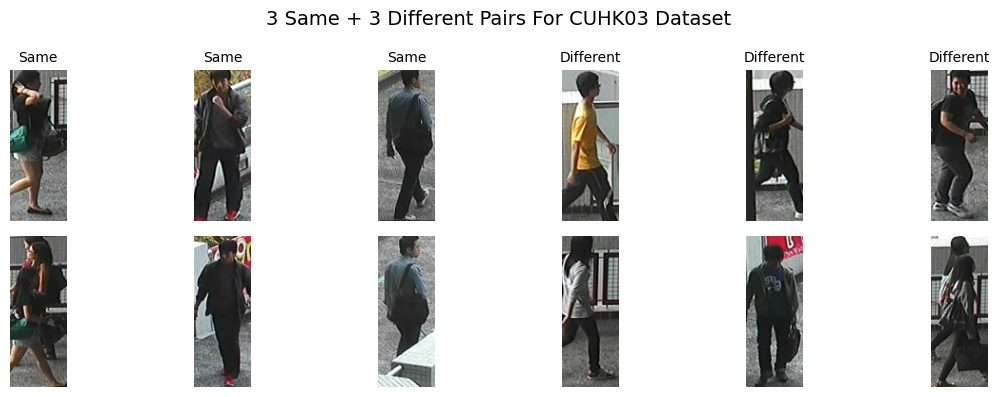

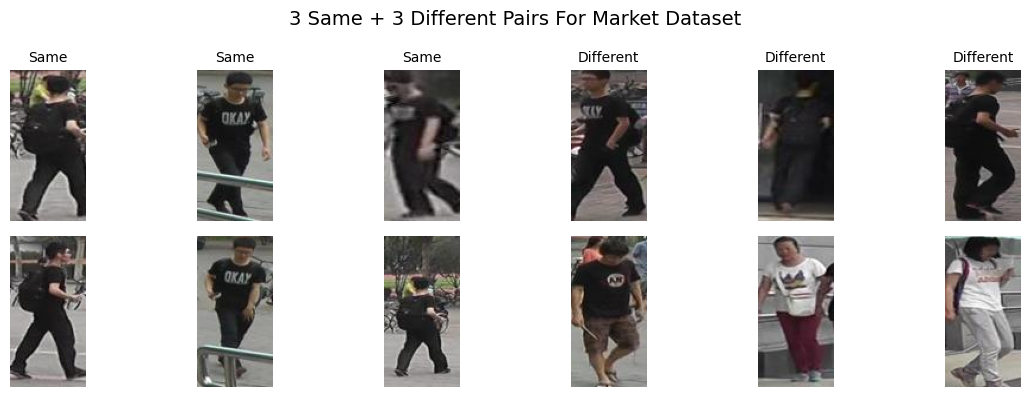

In [ ]:
import matplotlib.pyplot as plt

for dataset_name, dataset_loader in zip(["CUHK03", "Market"], [cuhk03_train_loader, market_test_loader]):
  # Grab a batch
  img1, img2, labels = next(iter(dataset_loader))

  # Select 3 same and 3 different
  same_idx = (labels == 1).nonzero(as_tuple=True)[0][:3]
  diff_idx = (labels == 0).nonzero(as_tuple=True)[0][:3]

  pairs = [(img1[i], img2[i], "Same") for i in same_idx] + \
          [(img1[i], img2[i], "Different") for i in diff_idx]

  # Plot: 2 rows × 6 columns
  fig, axes = plt.subplots(2, len(pairs), figsize=(2*len(pairs), 4))
  for c, (a, b, lbl) in enumerate(pairs):
      axes[0, c].imshow(a.permute(1,2,0).clamp(0,1))
      axes[0, c].axis("off")
      axes[1, c].imshow(b.permute(1,2,0).clamp(0,1))
      axes[1, c].axis("off")
      axes[0, c].set_title(lbl, fontsize=10)

  plt.suptitle("3 Same + 3 Different Pairs For "+dataset_name+" Dataset", fontsize=14)
  plt.tight_layout()
  plt.show()


# Creating the models and training

Model & Training Params

In [ ]:
# Training hyperparameters
PAIRS_PER_IMAGE = 10
BATCH_SIZE = 32
EPOCHS = 40
INITIAL_LR = 1e-2
DATASET_TAG = "CUHK03" # training datast

# Models
EXTRACTORS = list(_EXTRACTOR_REGISTRY.keys())
COMPARATORS = ["cosine_similarity", "attention", "lowrank_bilinear", "mlp"]

results = {}

## Train


========== Extractor: maskrcnn ==========


Processing:   0%|          | 0/929 [00:00<?, ?it/s]

Processing:   0%|          | 0/63 [00:00<?, ?it/s]


--- Comparator: cosine_similarity ---
Epoch 01/40 | train 3.6534 | val 2.4699 (acc 0.508) | lr 0.010000
Epoch 02/40 | train 1.5534 | val 0.8113 (acc 0.508) | lr 0.010000
Epoch 03/40 | train 0.7117 | val 0.6797 (acc 0.576) | lr 0.010000
Epoch 04/40 | train 0.6822 | val 0.6800 (acc 0.590) | lr 0.010000
Epoch 05/40 | train 0.6823 | val 0.6797 (acc 0.566) | lr 0.010000
Epoch 06/40 | train 0.6823 | val 0.6798 (acc 0.578) | lr 0.010000
Epoch 07/40 | train 0.6821 | val 0.6796 (acc 0.562) | lr 0.005000
Epoch 08/40 | train 0.6823 | val 0.6802 (acc 0.610) | lr 0.005000
Epoch 09/40 | train 0.6822 | val 0.6799 (acc 0.588) | lr 0.005000
Epoch 10/40 | train 0.6822 | val 0.6802 (acc 0.612) | lr 0.005000
Epoch 11/40 | train 0.6820 | val 0.6796 (acc 0.562) | lr 0.002500
Epoch 12/40 | train 0.6820 | val 0.6796 (acc 0.562) | lr 0.002500
Epoch 13/40 | train 0.6821 | val 0.6796 (acc 0.564) | lr 0.002500
Early stopping at epoch 13
Done in 19.2s | Best val loss = 0.6796 (epoch 7)
Saved best model & history 

Processing:   0%|          | 0/929 [00:00<?, ?it/s]

Processing:   0%|          | 0/63 [00:00<?, ?it/s]


--- Comparator: cosine_similarity ---
Epoch 01/40 | train 3.8548 | val 2.6593 (acc 0.508) | lr 0.010000
Epoch 02/40 | train 1.6845 | val 0.8731 (acc 0.508) | lr 0.010000
Epoch 03/40 | train 0.7305 | val 0.6928 (acc 0.508) | lr 0.010000
Epoch 04/40 | train 0.6930 | val 0.6927 (acc 0.508) | lr 0.010000
Epoch 05/40 | train 0.6929 | val 0.6933 (acc 0.492) | lr 0.010000
Epoch 06/40 | train 0.6929 | val 0.6933 (acc 0.492) | lr 0.010000
Epoch 07/40 | train 0.6931 | val 0.6929 (acc 0.592) | lr 0.005000
Epoch 08/40 | train 0.6929 | val 0.6928 (acc 0.500) | lr 0.005000
Epoch 09/40 | train 0.6929 | val 0.6927 (acc 0.506) | lr 0.005000
Epoch 10/40 | train 0.6929 | val 0.6927 (acc 0.508) | lr 0.005000
Epoch 11/40 | train 0.6929 | val 0.6928 (acc 0.508) | lr 0.002500
Epoch 12/40 | train 0.6930 | val 0.6928 (acc 0.540) | lr 0.002500
Epoch 13/40 | train 0.6928 | val 0.6929 (acc 0.492) | lr 0.002500
Early stopping at epoch 13
Done in 17.6s | Best val loss = 0.6927 (epoch 10)
Saved best model & history

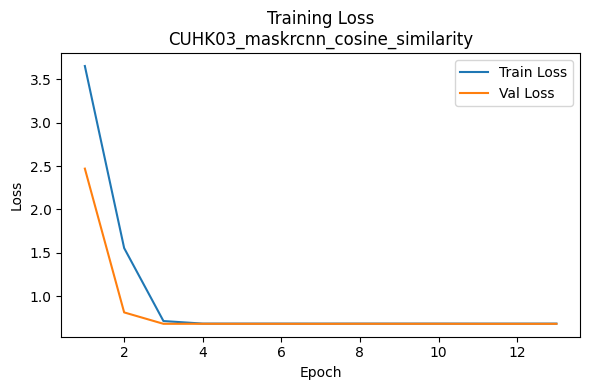

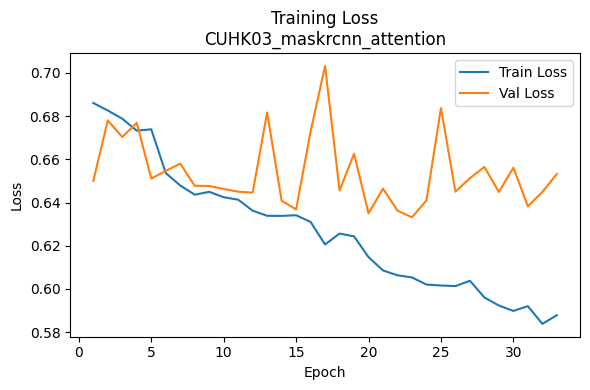

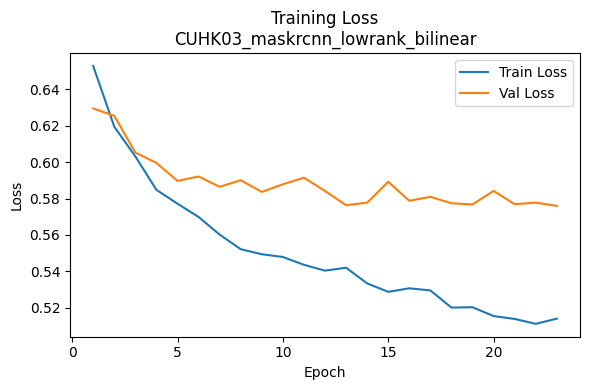

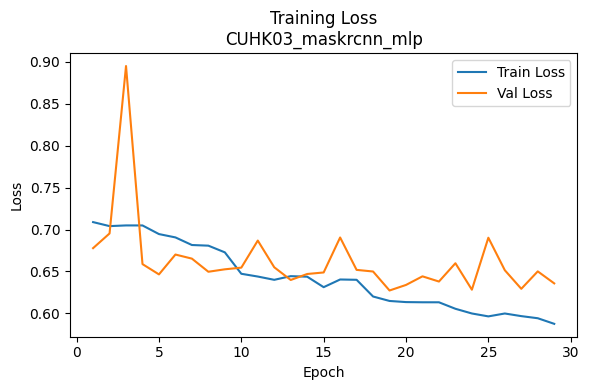

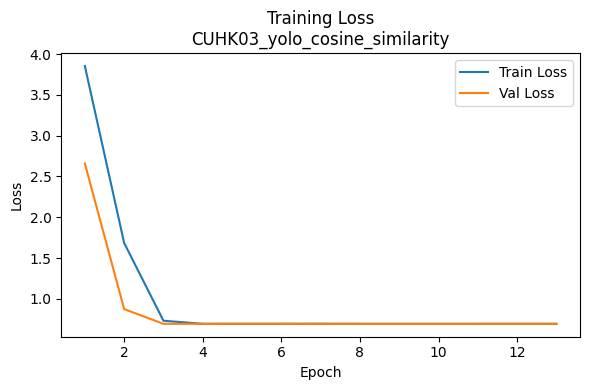

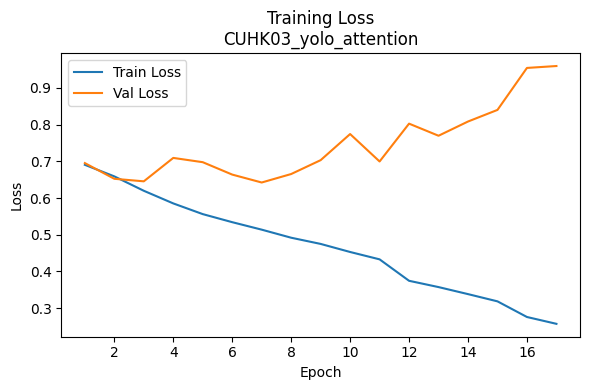

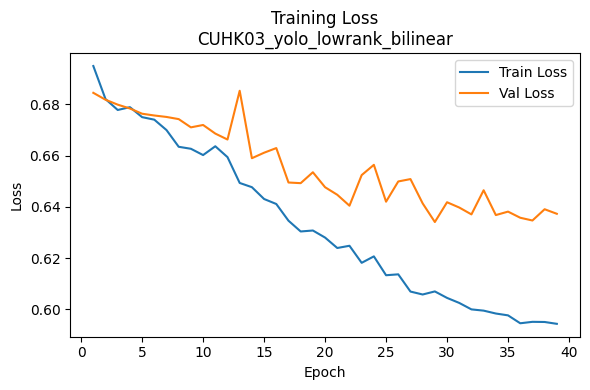

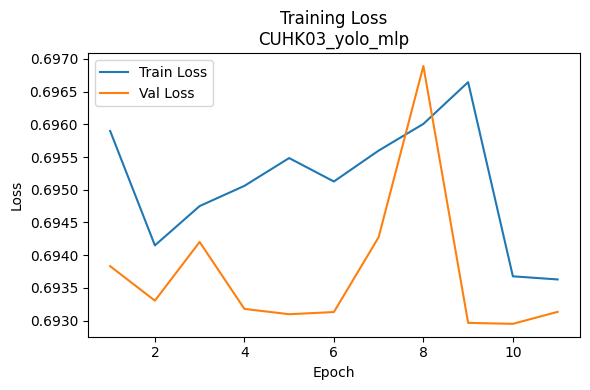

In [ ]:
# Loop over extractors
for extractor_name in EXTRACTORS:
    print(f"\n========== Extractor: {extractor_name} ==========")
    extractor = make_extractor(extractor_name, device)

    # Precompute dataset in feature space
    cuhk03_train_features_dataset = make_feature_datasets(cuhk03_train, extractor, device)
    cuhk03_val_features_dataset = make_feature_datasets(cuhk03_val, extractor, device)

    cuhk03_features_train_loader = DataLoader(
        cuhk03_train_features_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=2, pin_memory=True
    )
    cuhk03_features_val_loader = DataLoader(
        cuhk03_val_features_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=2, pin_memory=True
    )

    # Loop over comparators
    for comparator_name in COMPARATORS:
        print(f"\n--- Comparator: {comparator_name} ---")
        comparator = make_comparator(comparator_name, device)

        # Train
        final_val_loss, comparator, fig = train(
            extractor, comparator,
            cuhk03_features_train_loader, cuhk03_features_val_loader,
            device,
            epochs=EPOCHS, lr=INITIAL_LR, early_stopping_flag=True,
            dataset_tag=DATASET_TAG,
            extractor_name=extractor_name,
            comparator_name=comparator_name,
        )

        # Evaluate on validation set
        final_val_loss, final_val_acc = evaluate(
            extractor, comparator, cuhk03_features_val_loader, device
        )
        print(f"[{extractor_name} + {comparator_name}] "
              f"CUHK03 Val -> loss: {final_val_loss:.4f}, acc: {final_val_acc:.3f}")

        # Save results
        results[(extractor_name, comparator_name)] = {
            "val_loss": final_val_loss,
            "val_acc": final_val_acc
        }

    # Cleanup after this extractor to free the GPU
    del extractor
    del cuhk03_train_features_dataset, cuhk03_val_features_dataset
    del cuhk03_features_train_loader, cuhk03_features_val_loader
    gc.collect()
    torch.cuda.empty_cache()

print("\n========== Final Results ==========")
for (extractor_name, comparator_name), res in results.items():
    print(f"{extractor_name:15s} + {comparator_name:20s} "
          f"=> Val Loss: {res['val_loss']:.4f}, Val Acc: {res['val_acc']:.3f}")